In [1]:
import pandas as pd
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

PATH = r"..\Output\situation 4\results_sim.csv"
situation_num  = Path(PATH).parent.name.split()[-1]

results_dir = f"..\\results\\situation {situation_num}\\"
# Make directory if it does not exist
Path(results_dir).mkdir(parents=True, exist_ok=True)

data = pd.read_csv(PATH)
data['generation'] = data['scenario'].apply(lambda x: int(x.split('_')[0]))
data["scenario"] = data["scenario"].apply(lambda x: '_'.join(x.split('_')[1:]))
data["collision"] = data["collision"].fillna("None")

## Reorder columns
data = data[["generation", "scenario"] + [col for col in data.columns if col != "scenario" and col != "generation"]]

data["collision_happened"] = data["collision"].apply(lambda x: 0 if x == "None" else 1)

result = {}

# Fitness Analysis


In [2]:
gen_fitness = data.groupby("generation")["fitness"].mean().reset_index()

In [3]:
from scipy.stats import spearmanr, theilslopes

result["n_generations"] = len(gen_fitness)
if len(gen_fitness) >= 2:
    # Spearman rank correlation (robust to nonlinear relationships)
    rho, pval = spearmanr(gen_fitness["generation"], gen_fitness["fitness"])

    # Theil-Sen slope (robust to outliers)
    slope, intercept, low, high = theilslopes(gen_fitness["fitness"], gen_fitness["generation"])

    trend = "increasing" if slope > 0 else "decreasing" if slope < 0 else "flat"

    result["fitness_trend"] = {
        "spearman_rho": rho,
        "spearman_p_value": pval,
        "theil_sen_slope": slope,
        # "trend": trend,
        "confidence_interval": (low, high),
    }
else:
    result["fitness_trend"] = {"error": "Not enough generations to estimate trend."}

print(result)



{'n_generations': 50, 'fitness_trend': {'spearman_rho': 0.39524609843937575, 'spearman_p_value': 0.004500077961957344, 'theil_sen_slope': 0.590305806939565, 'confidence_interval': (0.02910072054164061, 1.8615563877210681)}}


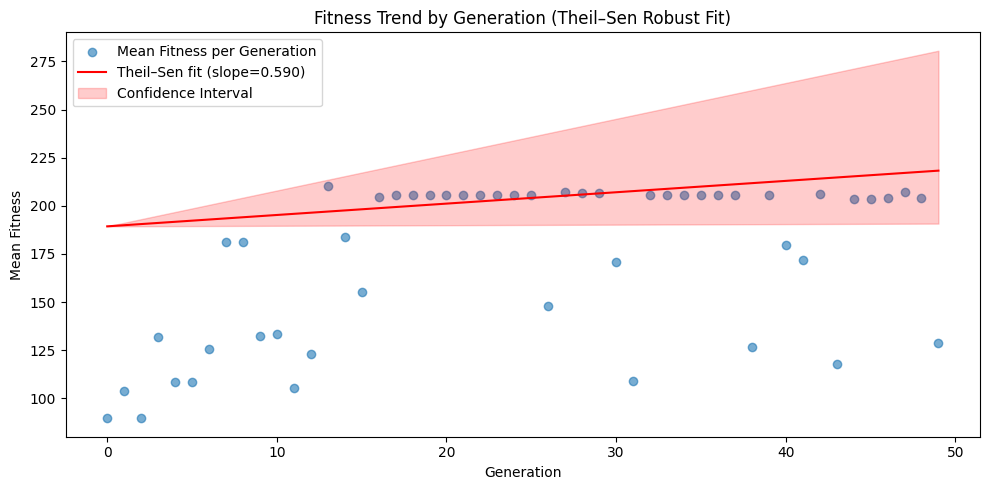

In [4]:
slope, intercept, low, high = theilslopes(gen_fitness["fitness"], gen_fitness["generation"])

# --- Plot 1: Theil–Sen trend line ---
plt.figure(figsize=(10,5))
plt.scatter(gen_fitness["generation"], gen_fitness["fitness"], alpha=0.6, label="Mean Fitness per Generation")
plt.plot(gen_fitness["generation"],
         intercept + slope * gen_fitness["generation"],
         color="red", label=f"Theil–Sen fit (slope={slope:.3f})")
plt.fill_between(gen_fitness["generation"],
                 intercept + low * gen_fitness["generation"],
                 intercept + high * gen_fitness["generation"],
                 color="red", alpha=0.2, label="Confidence Interval")
plt.title("Fitness Trend by Generation (Theil–Sen Robust Fit)")
plt.xlabel("Generation")
plt.ylabel("Mean Fitness")
plt.legend()
plt.tight_layout()
plt.savefig(results_dir + "fitness_trend_theilsen.png")
plt.show()

## Save plot

In [5]:
# gen_fitness["rolling_median"] = gen_fitness["fitness"].rolling(window=5, center=True).median()

# plt.figure(figsize=(10,5))
# plt.plot(gen_fitness["generation"], gen_fitness["fitness"], alpha=0.4, label="Mean Fitness")
# plt.plot(gen_fitness["generation"], gen_fitness["rolling_median"], color="orange", label="Rolling Median (window=5)")
# plt.title("Rolling Median of Fitness over Generations")
# plt.xlabel("Generation")
# plt.ylabel("Fitness")
# plt.legend()
# plt.tight_layout()
# plt.show()

# plt.savefig(results_dir + "fitness_trend_rolling_median.png")


# Collision Analaysis

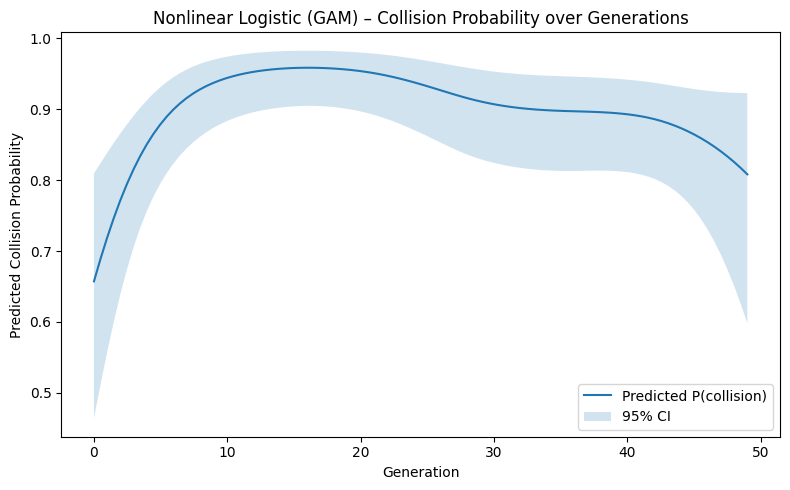

In [6]:
# Fit logistic regression
from pygam import LogisticGAM, s

# Fit a smooth GAM
gam = LogisticGAM(s(0, n_splines=10)).fit(data["generation"], data["collision_happened"])

# Plot the smooth effect
plt.figure(figsize=(8,5))
XX = np.linspace(data["generation"].min(), data["generation"].max(), 100)
plt.plot(XX, gam.predict_mu(XX), label="Predicted P(collision)")
plt.fill_between(XX,
                 gam.confidence_intervals(XX)[:,0],
                 gam.confidence_intervals(XX)[:,1],
                 alpha=0.2, label="95% CI")
plt.title("Nonlinear Logistic (GAM) – Collision Probability over Generations")
plt.xlabel("Generation")
plt.ylabel("Predicted Collision Probability")
plt.legend()
plt.tight_layout()
plt.savefig(results_dir + "collision_trend_gam.png")
plt.show()

In [7]:
from scipy.stats import norm
## Cochran–Armitage trend test for proportions

g = (data.dropna(subset=["generation", "collision_happened"])
       .groupby("generation")["collision_happened"]
       .agg(y="sum", n="size")
       .reset_index())

if len(g) < 2 or g["n"].sum() == 0:
    raise ValueError("Not enough grouped data for the trend test.")

x = g["generation"].values.astype(float)          # ordered scores
y = g["y"].values.astype(float)                   # successes
n = g["n"].values.astype(float)                   # totals

p_hat = y.sum() / n.sum()
x_bar_w = np.sum(n * x) / np.sum(n)

T = np.sum(x * (y - n * p_hat))
Var_T = p_hat * (1 - p_hat) * np.sum(n * (x - x_bar_w)**2)

if Var_T <= 0:
    raise ValueError("Variance is non-positive; check data.")

Z = T / np.sqrt(Var_T)
p_two_sided = 2 * (1 - norm.cdf(abs(Z)))

print({
    "Z_stat": float(Z),
    "p_value": float(p_two_sided),
    # "direction": "increasing" if Z > 0 else "decreasing" if Z < 0 else "flat",

})

result["collision_trend"] = {
    "Z_stat": float(Z),
    "p_value": float(p_two_sided),
}

{'Z_stat': 0.7247551829576898, 'p_value': 0.4686022346777654}


# Analyze Execution Time

{'n_generations': 50, 'fitness_trend': {'spearman_rho': 0.39524609843937575, 'spearman_p_value': 0.004500077961957344, 'theil_sen_slope': 0.590305806939565, 'confidence_interval': (0.02910072054164061, 1.8615563877210681)}, 'collision_trend': {'Z_stat': 0.7247551829576898, 'p_value': 0.4686022346777654}, 'execution_time_trend': {'spearman_rho': 0.13503344358496588, 'spearman_p_value': 0.34980271111711536, 'theil_sen_slope': 0.011363636363636364, 'confidence_interval': (0.0, 0.13333333333333344)}}


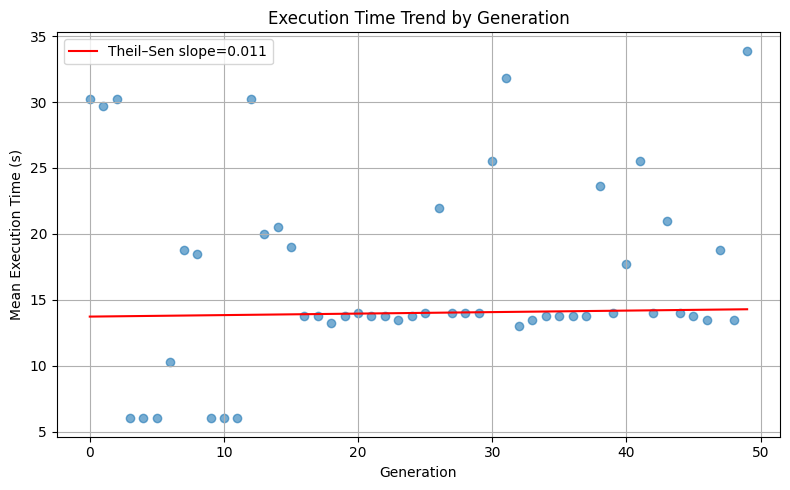

In [8]:
# Aggregate mean execution_time per generation
gen_exec = (data.dropna(subset=["generation", "execution_time"])
              .groupby("generation")["execution_time"]
              .mean()
              .reset_index())

# --- Spearman correlation ---
rho, pval = spearmanr(gen_exec["generation"], gen_exec["execution_time"])

# --- Theil–Sen slope ---
slope, intercept, low, high = theilslopes(gen_exec["execution_time"], gen_exec["generation"])

# --- Summarize results ---
result["execution_time_trend"] = {
    "spearman_rho": rho,
    "spearman_p_value": pval,
    "theil_sen_slope": slope,
    "confidence_interval": (low, high),
    # "trend": "increasing" if slope > 0 else "decreasing" if slope < 0 else "flat",
}
print(result)

# --- Optional visualization ---
plt.figure(figsize=(8,5))
plt.scatter(gen_exec["generation"], gen_exec["execution_time"], alpha=0.6)
plt.plot(gen_exec["generation"], intercept + slope * gen_exec["generation"],
         color="red", label=f"Theil–Sen slope={slope:.3f}")
plt.title("Execution Time Trend by Generation")
plt.xlabel("Generation")
plt.ylabel("Mean Execution Time (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir + "execution_time_trend_theilsen.png")
plt.show()

# Add description

In [9]:
## Round to 4 decimal places and save results
for key in result:
    if isinstance(result[key], dict):
        for subkey in result[key]:
            if isinstance(result[key][subkey], float):
                result[key][subkey] = round(result[key][subkey], 4)
            elif isinstance(result[key][subkey], tuple):
                result[key][subkey] = tuple(round(v, 4) for v in result[key][subkey])
    else:
        if isinstance(result[key], float):
            result[key] = round(result[key], 4)

            

In [10]:
result["fitness_trend"]["description"] = """Measures the trend of fitness values across generations. "
            "- Spearman’s rho indicates the direction and strength of a monotonic trend "
            "(positive → increasing, negative → decreasing). "
            "- The p-value tests the significance of that correlation (p < 0.05 → significant). "
            "- The Theil–Sen slope gives the estimated rate of change per generation, "
            "with its confidence interval showing uncertainty. "
            "→ Interpretation: If rho > 0 and p < 0.05, fitness is improving over generations; "
            "if rho < 0 and p < 0.05, it is deteriorating; otherwise, it is stable."""

result["collision_trend"]["description"] = """Assesses whether the probability of collisions changes monotonically with generation, "
            "using the Cochran–Armitage trend test. "
            "- Z_stat > 0 suggests an increasing trend in collision rate; "
            "Z_stat < 0 suggests a decreasing trend. "
            "- The p-value indicates significance (p < 0.05 → significant trend). "
            "→ Interpretation: If p < 0.05 and Z_stat < 0, collisions are decreasing (improving safety); "
            "if p < 0.05 and Z_stat > 0, collisions are increasing; otherwise, collision rate is stable."""

result["execution_time_trend"]["description"] = """Evaluates whether average execution time changes across generations. "
            "- Spearman’s rho measures monotonic direction; p-value tests significance. "
            "- The Theil–Sen slope estimates how execution time changes per generation. "
            "→ Interpretation: If rho > 0 and p < 0.05, execution time is increasing; "
            "if rho < 0 and p < 0.05, it is decreasing; if p ≥ 0.05 or the confidence interval crosses 0, "
            "there is no significant trend and execution time is stable."""

## Save as text file
results_path = results_dir + "trend_results.txt"
with open(results_path, "w", encoding="utf-8", errors="ignore") as f:
    for key in result:
        f.write(f"{key}:")
        if isinstance(result[key], dict):
            for subkey in result[key]:
                f.write(f" \n {subkey}: {result[key][subkey]}\n")
            f.write("\n")
            
        else:
            f.write(f" {result[key]}\n\n")
